# Generate student sports data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For testing our work
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
###############################################################################
#                                                                             #
# Settings. By all means change these.                                        #
#                                                                             #
###############################################################################

num_years = 3 # How many years to generate data for?

first_date = '2022-01-01' # What is the first date to generate (yyyy-mm-dd)

holiday_weeks = [52, 1, 8, 18, 42, 27, 28, 29, 30, 31, 32] # Weeks that are considered to be holidays.

first_school_week = 35

exam_weeks = [4, 8] # Weeks that are considered to be exam weeks

week_effect_coefficient = 0.9 # Strength of the weekly effect (school weeks at the start of a block have higher attendance than subsequent weeks)

ny_resolution_coefficient = 0.02 # Strength of the new years resolution effect (higher attendance in january, drops to 0 in june)

hourly_effect_coefficient = 0.8 # Strength of the hourly effect (hourly attendance increases as the day progresses, except during exam weeks)

holiday_multiplier = 0.9 # Multiplier for holiday weeks

baseline_attendance = 300.0 # Should be a float!!

hour_first = 10 # What is the first hour the gyms are open?
hour_last = 21 # What is the last hour the gyms are open?

noise_coefficient = 0.2 # How much randomness to add


## Generate dates

Include info on holidays and weekdays

In [4]:
df = pd.DataFrame()
df['date'] = pd.date_range(start=first_date, periods=365 * num_years, freq="D")
df['weekday'] = df['date'].dt.weekday
df['weeknum'] = df['date'].dt.isocalendar().week
df['is_holiday'] = df['weeknum'].map(lambda x : True if x in holiday_weeks else False )
df['is_weekday'] = df['weekday'].map(lambda x : True if x in [5, 6] else False)


## Generate school weeks


In [5]:
# Generate a map of week numbers to school weeks
week_school_week_map = {}
for weeknum in range (1, 53):
    week_school_week_map[weeknum] = 0
current_week = first_school_week - 1
current_school_week = 1
while True:
    current_week += 1
    if(current_week in holiday_weeks):
        continue

    week_school_week_map[current_week] = current_school_week
    current_school_week += 1
    if current_school_week > 10:
        current_school_week = 1
    if current_week > 52:
        current_week = 1
    if current_week == first_school_week - 1:
        break
# Hack: it's easier to do this manually (weeks before the start of the schoolyear)
week_school_week_map[33] = 0
week_school_week_map[34] = 0
# And this:
week_school_week_map[53] = 0
week_school_week_map[2] = 7
week_school_week_map[3] = 8
week_school_week_map[4] = 9

df['weeknum'] = df['weeknum'].map(int)
df['school_week'] = df['weeknum'].map(lambda x : week_school_week_map[x + 1])
df.loc[df['is_holiday'], 'school_week'] = 0







## Generate exam info

In [6]:
# Generate exam weeks
df['exam_week'] = df.apply(lambda row : True if(row['school_week'] in exam_weeks) else False , axis = 1)


# Generate attendance

Do this for one gym and then copy the data over to multiple gyms (if desired)

In [7]:
# Generate a linear effect for school weeks where attendance gradually drops as the schoolweek number increases,
# Only do this for non-exam weeks.

df['attendance_week_effect'] = 0.0
df.loc[df['exam_week'] == False, 'attendance_week_effect'] = ((10 - df['school_week']) / 10) * week_effect_coefficient

print("Values for weekly effect (excluding exam weeks):")
df['attendance_week_effect'].unique()



Values for weekly effect (excluding exam weeks):


array([0.9 , 0.  , 0.09, 0.81, 0.72, 0.63, 0.45, 0.36, 0.27])

In [8]:
# Generate a new year's resolution effect: attendance is highest in january (in non-exam weeks). This effect drops to 0 over 26 weeks
df['attendance_ny_effect'] = 0.0
df['ny_mult'] = (abs(df['weeknum'] - 53) - 26)
df['ny_mult'] = df['ny_mult'] * df['ny_mult'] / 26
df.loc[(df['exam_week'] == False) & (df['weeknum'] < 26), 'attendance_ny_effect'] = ny_resolution_coefficient * df['ny_mult']

print("Values for New Years' Resolution effect (excluding exam weeks):")
df['attendance_ny_effect'].unique()


Values for New Years' Resolution effect (excluding exam weeks):


array([0.        , 0.52      , 0.44307692, 0.40692308, 0.37230769,
       0.33923077, 0.30769231, 0.27769231, 0.24923077, 0.22230769,
       0.19692308, 0.15076923, 0.13      , 0.11076923, 0.09307692,
       0.07692308, 0.06230769, 0.03769231, 0.02769231, 0.01923077,
       0.00692308, 0.00307692])

In [9]:
# Generate hourly data
pd.options.mode.chained_assignment = None
df['hour'] = hour_first

# It turns out copying the whole mess to a regular array and updating that is much, much easier and more efficient than letting pandas handle this.
new_rows = []
for date in df['date'].unique():
    row = df[df['date'] == date].iloc[0]
    new_rows.append(row)
    for hour in range(hour_first + 1, hour_last + 1):
        new_row = row.copy(deep=True)
        # print(f"Adding hour {hour} to date {new_row['date']}")
        new_row.at['hour'] = hour
        new_rows.append(new_row)
pd.options.mode.chained_assignment = "warn"
df = pd.DataFrame(new_rows).reset_index().drop(columns=['index'])
df




,date,weekday,weeknum,is_holiday,is_weekday,school_week,exam_week,attendance_week_effect,attendance_ny_effect,ny_mult,hour
0,2022-01-01,5,52,True,True,0,False,0.9,0.00,24.038462,10
1,2022-01-01,5,52,True,True,0,False,0.9,0.00,24.038462,11
2,2022-01-01,5,52,True,True,0,False,0.9,0.00,24.038462,12
3,2022-01-01,5,52,True,True,0,False,0.9,0.00,24.038462,13
4,2022-01-01,5,52,True,True,0,False,0.9,0.00,24.038462,14
...,...,...,...,...,...,...,...,...,...,...,...
13135,2024-12-30,0,1,True,False,0,False,0.9,0.52,26.000000,17
13136,2024-12-30,0,1,True,False,0,False,0.9,0.52,26.000000,18
13137,2024-12-30,0,1,True,False,0,False,0.9,0.52,26.000000,19
13138,2024-12-30,0,1,True,False,0,False,0.9,0.52,26.000000,20


In [10]:
# Generate a linear effect, increasing attendance every hour except during exam weeks
df['attendance_hourly_effect'] = 0.0
df.loc[df['exam_week'] == False, 'attendance_hourly_effect'] =  hourly_effect_coefficient * (1 - ((24 - df['hour']) / 24)) 
print("Values for hourly effect (excluding exam weeks):")
df['attendance_hourly_effect'].unique()

Values for hourly effect (excluding exam weeks):


array([0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.        ])

In [11]:
# Generate holiday multiplier
df['holiday_multiplier'] = 1.0
df.loc[df['is_holiday'], 'holiday_multiplier'] = holiday_multiplier

In [12]:
# Now generate the final attendance (without noise).


df['attendance'] = (baseline_attendance + 
                    (baseline_attendance * df['attendance_ny_effect'])
                     + (baseline_attendance * df['attendance_week_effect'])
                      + (baseline_attendance * df['attendance_hourly_effect'])) * holiday_multiplier

In [13]:
# Apply some noise
noise = np.random.normal(loc=0.5, scale=0.1, size = len(df))
df.loc[df['attendance'] > 0, 'attendance'] = df['attendance'] + df['attendance'] * noise * noise_coefficient



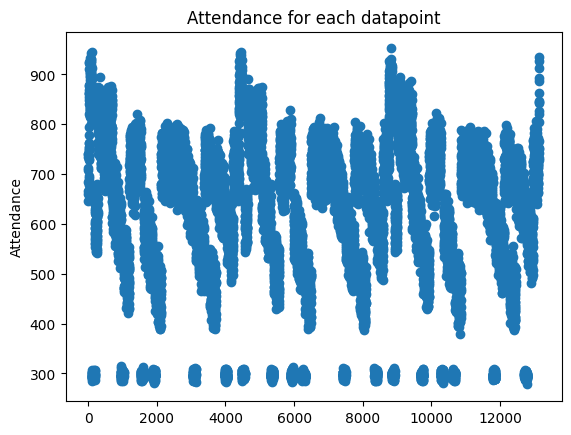

In [14]:

plt.scatter(df.index, df['attendance'])
plt.title('Attendance for each datapoint')
plt.ylabel('Attendance')
plt.xlabel('')
plt.show()

In [15]:
# Test the R^2 scores for a linear model.

df_no_exam = df[df['exam_week'] == False]
model_no_exam = LinearRegression()
model_no_exam.fit(df_no_exam[['school_week']], df_no_exam[['attendance']])
no_exam_weeks_score = model_no_exam.score(df_no_exam[['school_week']], df_no_exam[['attendance']] )
print(f'A linear model for non-exam school weeks has an R2 of {no_exam_weeks_score:.2f}')



model_all = LinearRegression()
model_all.fit(df[['school_week']], df[['attendance']])
all_weeks_score = model_all.score(df[['school_week']], df[['attendance']] )
print(f'A linear model for all school weeks has an R2 of {all_weeks_score:.2f}')





A linear model for non-exam school weeks has an R2 of 0.74
A linear model for all school weeks has an R2 of 0.53


# Done

If the results above are to our liking, we can save the dataset (to data/student_sports.csv)

In [16]:
df.loc[df['school_week'] == 0, 'school_week'] = None
df['attendance'] = df['attendance'].round().astype('int')
df = df[['date', 'hour', 'weekday', 'weeknum', 'is_holiday', 'school_week', 'exam_week', 'attendance']]
# df.to_csv('data/student_sports.csv', index=False)
df


,date,hour,weekday,weeknum,is_holiday,school_week,exam_week,attendance
0,2022-01-01,10,5,52,True,NaN,False,645
1,2022-01-01,11,5,52,True,NaN,False,659
2,2022-01-01,12,5,52,True,NaN,False,684
3,2022-01-01,13,5,52,True,NaN,False,666
4,2022-01-01,14,5,52,True,NaN,False,708
...,...,...,...,...,...,...,...,...
13135,2024-12-30,17,0,1,True,NaN,False,886
13136,2024-12-30,18,0,1,True,NaN,False,893
13137,2024-12-30,19,0,1,True,NaN,False,913
13138,2024-12-30,20,0,1,True,NaN,False,935
